<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/essential-graph-rag/02_advanced_vector_retrieval_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install -q pdfplumber
!pip install langchain-google-genai
!pip install neo4j

In [9]:
import re
from typing import List

import os
import pdfplumber
import requests

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from google.colab import userdata

In [10]:
# --- Configuration ---
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [11]:
# Initialize the ChatGoogleGenerativeAI model
# Use a model that supports audio input, like "gemini-1.5-flash" or "gemini-1.5-pro"
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    streaming=True,
    api_key=userdata.get("GOOGLE_API_KEY")
)

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [12]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(
    userdata.get("NEO4J_URI"),
    auth=(userdata.get("NEO4J_USERNAME"), userdata.get("NEO4J_PASSWORD"))
)

In [14]:
def chunk_text(text, chunk_size, overlap, split_on_whitespace_only=True):
    chunks = []
    index = 0

    while index < len(text):
        if split_on_whitespace_only:
            prev_whitespace = 0
            left_index = index - overlap
            while left_index >= 0:
                if text[left_index] == " ":
                    prev_whitespace = left_index
                    break
                left_index -= 1
            next_whitespace = text.find(" ", index + chunk_size)
            if next_whitespace == -1:
                next_whitespace = len(text)
            chunk = text[prev_whitespace:next_whitespace].strip()
            chunks.append(chunk)
            index = next_whitespace + 1
        else:
            start = max(0, index - overlap + 1)
            end = min(index + chunk_size + overlap, len(text))
            chunk = text[start:end].strip()
            chunks.append(chunk)
            index += chunk_size

    return chunks


def num_tokens_from_string(string: str, model: str = "gpt-4") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def embed(text_chunks):
    embeddings_list = []
    for text_chunk in text_chunks:
        embeddings = gemini_embeddings.embed_query(text_chunk)
        embeddings_list.append(embeddings)
    return embeddings_list


def chat(messages):
    response = llm.invoke(messages)
    return response.content


## Step-back Prompting

Step-back prompting is a query-rewriting technique that aims to
improve the accuracy of vector retrieval.

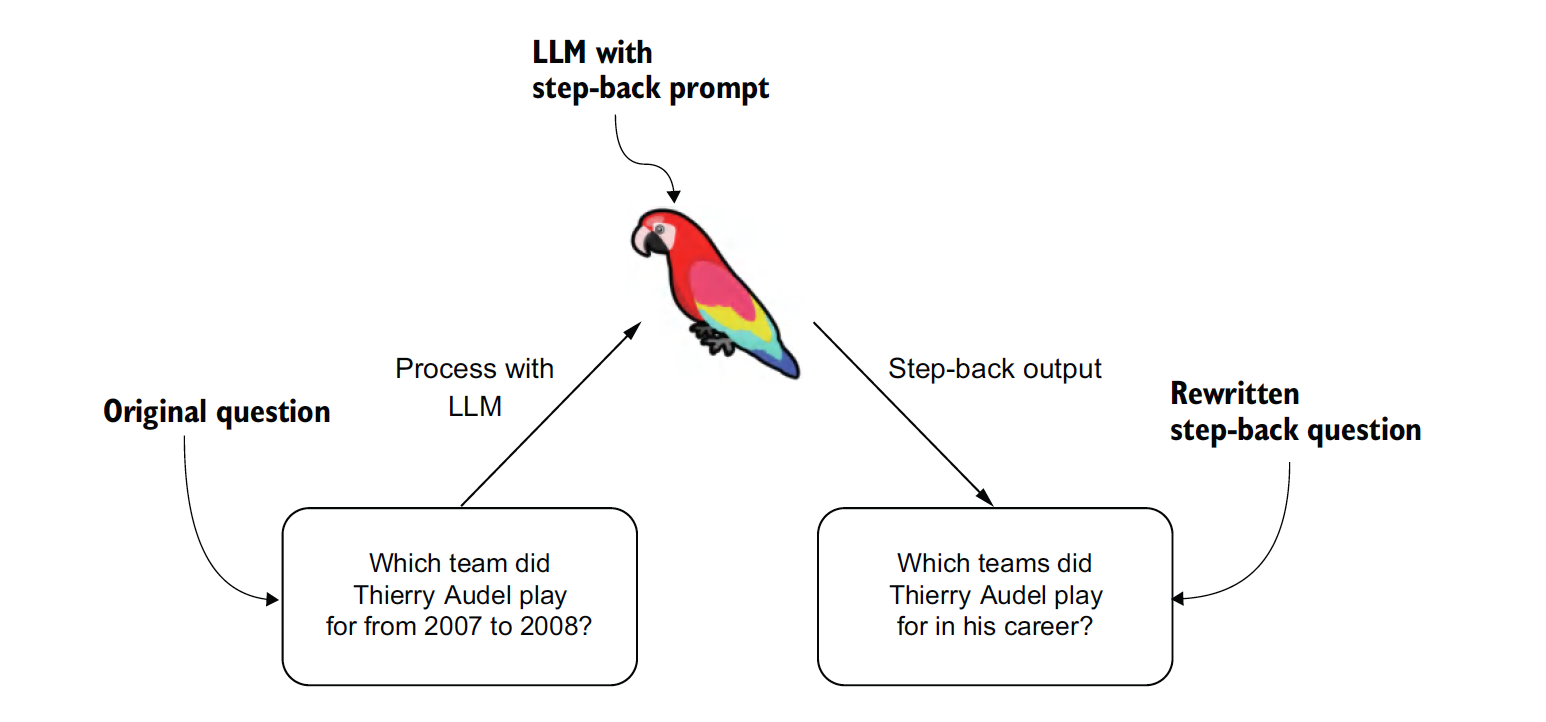

LLMs are an excellent fit for query-rewriting tasks as they excel at natural language
comprehension and generation. You don’t have to train or finetune a new model for
each task.

In [15]:
stepback_system_message = """
You are an expert at world knowledge. Your task is to step back
and paraphrase a question to a more generic step-back question, which
is easier to answer. Here are a few examples

"input": "Could the members of The Police perform lawful arrests?"
"output": "what can the members of The Police do?"

"input": "Jan Sindel’s was born in what country?"
"output": "what is Jan Sindel’s personal history?"
"""


def generate_stepback(question: str):
    user_message = f"""{question}"""
    step_back_question = chat(
        messages=[
            {"role": "system", "content": stepback_system_message},
            {"role": "user", "content": user_message},
        ]
    )
    return step_back_question

In [16]:
question = "Which team did Thierry Audel play for from 2007 to 2008?"
step_back_question = generate_stepback(question)
print(f"Stepback results: {step_back_question}")

Stepback results: What is Thierry Audel's playing history?


In [17]:
question = "When India got freedom from British?"
step_back_question = generate_stepback(question)
print(f"Stepback results: {step_back_question}")

Stepback results: What is India's independence?


## Parent document retriever

In [ ]:
remote_pdf_url = "https://arxiv.org/pdf/1709.00666.pdf"
pdf_filename = "ch03-downloaded.pdf"

response = requests.get(remote_pdf_url)

if response.status_code == 200:
    with open(pdf_filename, "wb") as pdf_file:
        pdf_file.write(response.content)
else:
    print("Failed to download the PDF. Status code:", response.status_code)

In [ ]:
text = ""

with pdfplumber.open(pdf_filename) as pdf:
    for page in pdf.pages:
        text += page.extract_text()

In [ ]:
def split_text_by_titles(text):
    # A regular expression pattern for titles that
    # match lines starting with one or more digits, an optional uppercase letter,
    # followed by a dot, a space, and then up to 50 characters
    title_pattern = re.compile(r"(\n\d+[A-Z]?\. {1,3}.{0,60}\n)", re.DOTALL)
    titles = title_pattern.findall(text)
    # Split the text at these titles
    sections = re.split(title_pattern, text)
    sections_with_titles = []
    # Append the first section
    sections_with_titles.append(sections[0])
    # Iterate over the rest of sections
    for i in range(1, len(titles) + 1):
        section_text = sections[i * 2 - 1].strip() + "\n" + sections[i * 2].strip()
        sections_with_titles.append(section_text)

    return sections_with_titles


sections = split_text_by_titles(text)
print(f"Number of sections: {len(sections)}")

Number of sections: 9


In [ ]:
for s in sections:
    print(num_tokens_from_string(s))

154
254
4186
570
2703
804
637
194
600


In [ ]:
print(sections[1])

1. Introduction
Towards the end of the last century, Times Magazine asked some of the World’s leading
personalities to pick their choice for the person of the century. The magazine compiled a list 100 most
influential people of 20th century and the German born scientist Albert Einstein topped the list.
Einstein’s choice as the person of the century didn’t invoke any resentment, it was generally agreed
that 20th century is the age of Science and undoubtedly, Einstein’s contribution to Science, to the
understanding of the intricate laws of nature was unparalleled. He greatly influenced modern science;
altered our views on space‐time, matter and energy, gave new interpretation to gravity etc. The
enormous popularity he enjoyed during his lifetime and even now, is rare for any individual; religious
leader, politician, film star. Even a child knows his name, not to speak of adults.
However, while Einstein is known as a great theoretical physicist, few possibly knew that he
had more than 50 

In [ ]:
parent_chunks = []
for s in sections:
    parent_chunks.extend(chunk_text(s, 2000, 40))

In [ ]:
cypher_import_query = """
MERGE (pdf:PDF {id:$pdf_id})
MERGE (p:Parent {id:$pdf_id + '-' + $id})
SET p.text = $parent
MERGE (pdf)-[:HAS_PARENT]->(p)
WITH p, $children AS children, $embeddings as embeddings
UNWIND range(0, size(children) - 1) AS child_index
MERGE (c:Child {id: $pdf_id + '-' + $id + '-' + toString(child_index)})
SET c.text = children[child_index], c.embedding = embeddings[child_index]
MERGE (p)-[:HAS_CHILD]->(c);
"""

In [ ]:
for i, chunk in enumerate(parent_chunks):
    child_chunks = chunk_text(chunk, 500, 20)
    embeddings = embed(child_chunks)
    # Add to neo4j
    neo4j_driver.execute_query(
        cypher_import_query,
        id=str(i),
        pdf_id="1709.00666",
        parent=chunk,
        children=child_chunks,
        embeddings=embeddings,
    )

In [ ]:
index_name = "parent"
driver.execute_query("""CREATE VECTOR INDEX parent IF NOT EXISTS
FOR (c:Child)
ON c.embedding""")

Vector Index already exists


In [ ]:
retrieval_query = """
CALL db.index.vector.queryNodes($index_name, $k * 4, $question_embedding)
YIELD node, score
MATCH (node)<-[:HAS_CHILD]-(parent)
WITH parent, max(score) AS score
RETURN parent.text AS text, score
ORDER BY score DESC
LIMIT toInteger($k)
"""

In [ ]:
def parent_retrieval(question: str, k: int = 4) -> List[str]:
    question_embedding = embed([question])[0]

    similar_records, _, _ = neo4j_driver.execute_query(
        retrieval_query,
        question_embedding=question_embedding,
        k=k,
        index_name=index_name,
    )

    return [record["text"] for record in similar_records]

In [ ]:
documents = parent_retrieval(
    "Who was the Einsten's collaborator on sound reproduction system?"
)
for d in documents:
    print(d)
    print("=" * 20)

113B. Sound reproduction system with Rudolf Goldschmidt
Rudolf Goldschmidt was a German Engineer and inventor. He earned his engineering degree
in 1898 and PhD in 1906. He spent a decade working in England with major firms such as Crampton,
Arc works, Westinghouse etc. On returning back to Germany he joined Darmstadt T H University as a
professor. Goldschmidt was a prolific inventor. His first patent was for a bicycle gear while still an
engineering student. In 1908 he developed a rotating radio‐frequency machine, which was used as an
early radio transmitter. The transmitter was used in the first trans‐Atlantic radiotelegraphic link
between Germany and United States, opened on 19th June, 1914, with an exchange of telegrams
between Kaiser Wilhelm II and President Woodrow Wilson.
Figure 5: Einstein‐Goldschmidt design of a sound reproduction system.
In 1922 Goldschmidt approached Einstein for his expert opinion regarding one of his patents.
Thereafter, they kept in touch. Even after Einst

In [ ]:
generate_stepback("Who was the Einsten's collaborator on sound reproduction system?")

"Who were Einstein's professional associates?"

In [ ]:
answer_system_message = "You're en Einstein expert, but can only use the provided documents to respond to the questions."


def generate_answer(question: str, documents: List[str]) -> str:
    user_message = f"""
    Use the following documents to answer the question that will follow:
    {documents}

    ---

    The question to answer using information only from the above documents: {question}
    """
    result = chat(
        messages=[
            {"role": "system", "content": answer_system_message},
            {"role": "user", "content": user_message},
        ]
    )
    print("Response:", result)

In [ ]:
def rag_pipeline(question: str) -> str:
    stepback_prompt = generate_stepback(question)
    print(f"Stepback prompt: {stepback_prompt}")
    documents = parent_retrieval(stepback_prompt)
    answer = generate_answer(question, documents)
    return answer

In [ ]:
rag_pipeline("Who was the Einsten's collaborator on sound reproduction system?")

Stepback prompt: Who were Einstein's professional associates?
Response: The documents provided do not contain information on who collaborated with Einstein on a sound reproduction system.
